# Monatomic gases

The Sackur-Tetrode equation provides a way to *directly* calculate the entropy of a monatomic ideal gas, based on statistical thermodynamics. It can be expressed as

$$
\overline{s} = R_{\text{univ}} \left[ \ln \left( \frac{k T}{P} \right) + \ln \left( \left[ \frac{2 \pi m k T}{h^2} \right]^{3/2} \right) + \frac{5}{2} \right] \;,
$$

where 

* $R_{\text{univ}}$ is the universal gas constant
* $k$ is Boltzmann's constant
* $T$ is the temperature
* $P$ is the pressure
* $m$ is the mass of a gas particle, $m = \frac{MW}{N_A}$
* $N_A$ is Avogadro's number
* $h$ is the Planck constant

To actually calculate entropy using this equation, where we want to handle units properly, we need to manipulate the equation slightly:

$$
\overline{s} = R_{\text{univ}} \left[ \ln \left( \frac{k T}{P} \left[ \frac{2 \pi m k T}{h^2} \right]^{3/2} \right) + \frac{5}{2} \right] \;,
$$

We can compare this way of calculating entropy with values obtained from Cantera, which are based on the NASA thermochemical database.

In [1]:
import numpy as np
import cantera as ct
from scipy.constants import physical_constants

from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity

# for convenience:
def to_si(quant):
    '''Converts a Pint Quantity to magnitude at base SI units.
    '''
    return quant.to_base_units().magnitude

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# these are mostly for making the saved figures nicer
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['figure.dpi']= 150
plt.rcParams['savefig.dpi'] = 150

In [3]:
# Obtain needed physical constants and their units

planck_constant = Q_(
   physical_constants['Planck constant'][0], 
   physical_constants['Planck constant'][1]
   )

boltzmann_constant = Q_(
    physical_constants['Boltzmann constant'][0],
    physical_constants['Boltzmann constant'][1]
    )

avogadro_number = Q_(
    physical_constants['Avogadro constant'][0],
    physical_constants['Avogadro constant'][1]
    )

gas_constant = Q_(
    physical_constants['molar gas constant'][0],
    physical_constants['molar gas constant'][1],
    )

Cantera includes the NASA thermochemical database {cite}`Gordon1971,McBride1993`, which contains fits for a large number of gases, including argon, helium, and monatomic oxygen.

In [4]:
# Extract species from NASA thermochemical database

species = ['Ar', 'He', 'O']

species_objects = {S.name: S for S in ct.Species.listFromFile('nasa_gas.cti')}
gas = ct.Solution(thermo='IdealGas', species=[species_objects[S] for S in species])

In [5]:
def get_entropy(temperature, pressure, species, gas):
    """Calculates entropy of species using Sackur-Tetrode equation"""
    idx = gas.species_index(species)
    molecular_weight = Q_(gas.molecular_weights[idx], 'g/mol')
    mass = molecular_weight / avogadro_number
        
    entropy = gas_constant * (np.log(
        boltzmann_constant * temperature * (
            2 * np.pi * mass * boltzmann_constant * temperature / 
            planck_constant**2
            ) ** 1.5 / pressure
        ) + 5.0 / 2.0)
    
    return entropy

Let's calculate the entropy of these species over the range 200–1000 K and at 1 atm, comparing the two approaches:

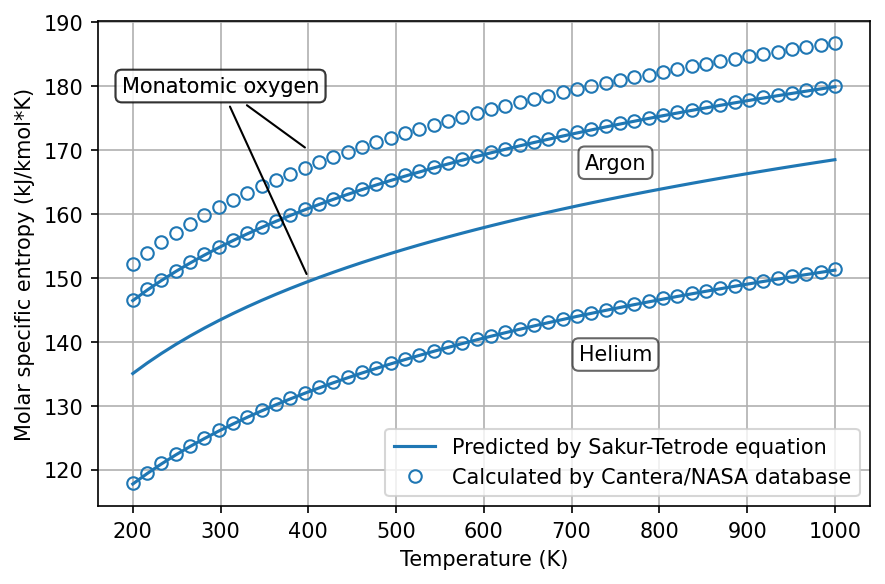

In [6]:
pressure = Q_(1, 'atm')

# range of temperatures in K
temperatures = np.linspace(200, 1000, 50) * Q_('K')

for species in gas.species():
    
    entropies = np.zeros(len(temperatures)) * Q_('J/(K*kmol)')
    entropies_ct = np.zeros(len(temperatures)) * Q_('J/(K*kmol)')
    
    for idx, temperature in enumerate(temperatures):
        gas.TPX = to_si(temperature), to_si(pressure), f'{species.name}:1.0'
        entropies_ct[idx] = Q_(gas.entropy_mole, 'J/(K*kmol)')
        
        entropies[idx] = get_entropy(temperature, pressure, species.name, gas)
    
    plt.plot(
        to_si(temperatures), entropies.to('kJ/(kmol*K)').magnitude, '-',
        color='tab:blue',
        )
    plt.plot(
        to_si(temperatures), entropies_ct.to('kJ/(kmol*K)').magnitude, 'o', 
        fillstyle='none', color='tab:blue'
        )
    
plt.xlabel('Temperature (K)')
plt.ylabel('Molar specific entropy (kJ/kmol*K)')

# text box properties
props = dict(boxstyle='round', facecolor='white', alpha=0.6)

plt.text(750, 168, 'Argon', bbox=props, ha='center', va='center')
plt.text(750, 138, 'Helium', bbox=props, ha='center', va='center')

plt.annotate(
    'Monatomic oxygen', xy=(400,170), xytext=(300,180),
    ha='center', va='center', bbox=props,
    arrowprops=dict(arrowstyle='-')
    )
plt.annotate(
    'Monatomic oxygen', xy=(400,150), xytext=(300,180),
    ha='center', va='center', bbox=props,
    arrowprops=dict(arrowstyle='-')
    )

plt.grid(True)
plt.legend([
    'Predicted by Sakur-Tetrode equation', 
    'Calculated by Cantera/NASA database'
    ])
plt.tight_layout()
plt.show()

As we can see, two approaches to calculating entropy of agree nearly perfectly for helium and argon; these behave very much like ideal gases for this range of conditions.

On the other hand, monatomic oxygen (O) does *not* obey the ideal gas law; it exhibits strong inter-particle forces. (Oxygen normally exists as the O$_2$ molecule, and monatomic oxygen is typically short-lived.)